In [18]:
import pandas as pd
import os
import sys
sys.path.append('/cellar/users/snwright/Git/rare_common/carva')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon'
inputdir=os.path.join(datadir, 'inputs')
annotdir=os.path.join(datadir, 'outputs/Features')
outdir=os.path.join(datadir, 'outputs/netcoloc/March_2025')

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

# Load data

## Load NetColoc results

In [4]:
best_df = pd.read_csv(os.path.join(outdir, 'coloc_repeat_best_results.tsv'), sep='\t')
best_df = best_df.rename(columns={'trait_type_x':'trait_type'})


In [5]:
best_df.shape

(373, 25)

## Load additional meta data

In [6]:
domain_info = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/TissEnrich/gcat_meta.txt', sep=',', usecols=['EFO', 'Domain']).drop_duplicates()
best_df = best_df.merge(domain_info, on=['EFO'], how='left')

In [7]:
initial_df = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_Mar28.tsv'), sep='\t', 
                         usecols=['N_R', 'N_C','StudyC', 'StudyR', 'Cosine_C', 'Cosine_R',
                                 'COHORT_C', 'COHORT_R'])
repeat_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/inputs/repeat_study_info.txt', sep='\t',
                       usecols=['N_R', 'N_C', 'StudyC', 'StudyR', 'Cosine_C', 'Cosine_R', 
                                'COHORT_C', 'COHORT_R'])
info_df = pd.concat([initial_df, repeat_df])
info_df['trait_pair'] = info_df['StudyR'] + '_' + info_df['StudyC']
info_df = info_df[info_df.trait_pair.isin(best_df.trait_pair.values)]

In [8]:
best_df = best_df.merge(info_df, on='trait_pair')

In [9]:
# have an issue with there being multiple mappings to the same study-trait for rare traits. need to extract the actual one.

In [10]:
overlap_data = pd.read_csv(os.path.join(datadir, 'outputs/overlap/March_2025', 'best_RV_GC_overlap.txt'), sep='\t', header=None,
                          names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'overlap_pval'])
overlap_data['overlap_logq'] = -1*np.log10(fdrcorrection(overlap_data.overlap_pval)[1] + 1e-250)
overlap_data['jaccard'] = overlap_data.apply(lambda x: x.n_overlap /(x.n_common+x.n_rare-x.n_overlap), axis=1)

In [11]:
best_df = best_df.merge(overlap_data.loc[:, ('trait_pair', 'n_common', 'n_rare', 'n_overlap', 'overlap_logq', 'jaccard')],
                       on='trait_pair')

In [207]:
best_df.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,StudyR,Cosine_C,Cosine_R,COHORT_C,COHORT_R,n_common,n_rare,n_overlap,overlap_logq,jaccard
0,34375979_EFO_0004533,GCST90025947_EFO_0004533,pcnet2_0,neglog10,sum,0.664222,0.001413,0.0,925,151.612,...,34375979_EFO_0004533,0.821392,1.000000,UKB,UKB,16,8,6,20.422890,0.333333
1,34662886_EFO_0005091,GCST90025950_EFO_0005091,pcnet2_0,neglog10,sum,1.130764,0.053103,0.0,1257,209.545,...,34662886_EFO_0005091,1.000000,0.592364,UKB,UKB,16,12,7,21.861410,0.333333
2,36088354_EFO_0006925,GCST90019513_EFO_0006925,pcnet2_0,neglog10,sum,0.799962,0.025011,0.0,1029,176.766,...,36088354_EFO_0006925,0.803270,1.000000,UKB,UKB,23,12,11,34.805585,0.458333
3,34662886_EFO_0007805,GCST90025956_EFO_0007805,pcnet2_0,neglog10,sum,1.239503,0.050480,0.0,1361,244.828,...,34662886_EFO_0007805,0.840222,0.870126,UKB,UKB,22,25,14,38.348037,0.424242
4,36088354_EFO_0004531,GCST90025965_EFO_0004531,pcnet2_0,neglog10,sum,0.685343,0.015044,0.0,920,177.244,...,36088354_EFO_0004531,0.693784,1.000000,UKB,UKB,15,5,3,11.425966,0.176471


## Load genesets

In [208]:
r_traitlist = best_df.TraitR.values
c_traitlist = best_df.TraitC.values
all_pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]
len(all_pairs)

373

## Load network features

In [211]:
# Load network results
net = []
for pair in all_pairs:
    try:
        x = pd.read_csv(os.path.join(datadir, 'outputs/Features/network_stats', f'network_stats_pcnet2_0_best_rare.traitlist.{pair}'), sep='\t', low_memory=False)
        net.append(x)
    except FileNotFoundError:
        print(f'{pair} not found')

In [212]:
netdf = pd.concat(net)

In [226]:
def extract_subAssort(instr):
    outstr = instr.replace('(', '').replace(')', '').split(', ')
    return [float(x) for x in outstr] 

In [232]:
rc_assortativity = netdf.loc[netdf.varset=='rare_common', ('trait', 'varset', 'subnetwork_assortativity')]
rc_assortativity['subnetAssort'] = rc_assortativity.subnetwork_assortativity.apply(lambda x:x if isinstance(x, float) else np.mean(extract_subAssort(x)))

In [266]:
net_df = netdf.drop(columns='subnetwork_assortativity').merge(rc_assortativity.drop(columns='subnetwork_assortativity'), on=['trait', 'varset'], how='left')

In [267]:
net_df = net_df.merge(best_df.loc[:, ('n_rare', 'n_common', 'n_overlap', 'trait_pair', 'EFO')], 
                      left_on='trait', right_on='trait_pair').drop(columns='trait')

In [ ]:
# Load modularities

In [468]:
net_df.head()

,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort,n_rare,n_common,n_overlap,trait_pair,EFO
0,rare,0.250000,3,314.125000,1.750000,0.204771,0.291667,0.005247,1.821429,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533
1,common,0.116667,7,284.000000,1.750000,0.236188,0.200000,0.005575,2.050000,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533
2,overlap,0.266667,2,289.666667,1.333333,0.201191,0.000000,0.004378,1.866667,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533
3,rare_common,0.130719,8,295.500000,2.222222,0.235343,0.303704,0.006835,2.026144,0.007724,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533
4,rare,0.227273,2,400.916667,2.500000,0.228749,0.302778,0.005615,1.787879,NaN,12,16,7,34662886_EFO_0005091_GCST90025950_EFO_0005091,EFO_0005091


In [474]:
mod_df = pd.read_csv(os.path.join(datadir, 'outputs/Features/network_stats', 'network_modularities_pcnet2_0_best_rare.traitlist'), sep='\t')
trait_list = pd.read_csv(os.path.join(datadir, 'inputs/March_2025/best_rare.traitlist'), header=None, names=['TraitR'])
mod_df = pd.concat([mod_df, trait_list], axis=1)
mod_df = mod_df.melt(id_vars='TraitR', var_name='varset', value_name='Modularity')
mod_df['varset'] = mod_df['varset'].map({'Modularity_common':'common', 'Modularity_rare':'rare', 
                                         'Modularity_overlap':'overlap', 'Modularity_all':'rare_common',
                                        'Modularity_subnetwork':'subnetwork'})

In [475]:
sub_mod = mod_df[mod_df.varset=='subnetwork']
sub_mod = sub_mod.assign(varset= 'rare_common')
sub_mod = sub_mod.rename(columns={'Modularity':'SubnetMod'})

In [476]:
mod_df = mod_df.merge(sub_mod, on=['TraitR', 'varset'], how='left')

In [478]:
mod_df = mod_df.assign(EFO=mod_df.TraitR.map(best_df.set_index('TraitR').EFO.to_dict()))

#### Put both together

In [483]:
net_df = net_df.merge(mod_df.drop(columns=['TraitR']), on=['varset', 'EFO'])

## Load bio features

# Initial input features

## Feature Engineering

## Feature correlations + values

## Feature engineering + normalization

In [13]:
input_df = best_df.loc[:, ('EFO', 'log2SizeOE', 'logq', 'jaccard', 'N_R', 'N_C', 'Cosine_C', 'Cosine_R', 
                           'overlap_logq', 'n_common', 'n_rare', 'n_overlap', 'trait_type')].set_index('EFO')

In [14]:
input_df['maxN'] = input_df.apply(lambda x: max(x.N_C, x.N_R), axis=1)
input_df['minN'] = input_df.apply(lambda x: min(x.N_C, x.N_R), axis=1)
input_df['meanCosine'] = input_df.apply(lambda x: np.mean([x.Cosine_C, x.Cosine_R]), axis=1)
input_df['Gene_ratio']= input_df.apply(lambda x: min(x.n_common, x.n_rare)/max(x.n_common, x.n_rare), axis=1)
input_df['binary'] = input_df.trait_type.apply(lambda x: 1 if x=='CC' else 0)
input_df['jaccard_zero'] = input_df.jaccard.apply(lambda x: 1 if x ==0  else 0)
#input_df['minGenes']= input_df.apply(lambda x: min(x.n_common, x.n_rare), axis=1)

In [15]:
input_df = input_df.drop(columns=['N_C', 'N_R', 'n_rare', 'n_common', 'Cosine_R', 'Cosine_C',
                                     'overlap_logq', 'n_overlap', 'trait_type'])

,jaccard,maxN,minN,meanCosine,Gene_ratio,binary,jaccard_zero
jaccard,1.000000,-0.426922,0.188643,0.030119,0.123724,-0.500382,-0.911597
maxN,-0.426922,1.000000,0.401152,-0.088344,-0.047810,0.386521,0.349407
minN,0.188643,0.401152,1.000000,0.049007,-0.064532,-0.019963,-0.233850
meanCosine,0.030119,-0.088344,0.049007,1.000000,-0.094736,0.178731,0.013677
Gene_ratio,0.123724,-0.047810,-0.064532,-0.094736,1.000000,0.026407,0.017196
binary,-0.500382,0.386521,-0.019963,0.178731,0.026407,1.000000,0.452861
jaccard_zero,-0.911597,0.349407,-0.233850,0.013677,0.017196,0.452861,1.000000


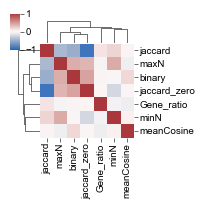

In [16]:
sns.clustermap(input_df.drop(columns=['logq','log2SizeOE' ]).corr(method='spearman'), 
               figsize=(2,2), cmap='vlag', center=0, vmin=-1)
input_df.drop(columns=['logq',   'log2SizeOE']).corr(method='spearman')

In [351]:
def compare_transforms(input_df, col, log=False):
    _, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1, figsize=(5, 6))
    if log:
        X = np.log10(input_df[col].values).reshape(-1,1)
    else:
        X = input_df[col].values.reshape(-1,1)
    transformer1 = prep.QuantileTransformer(n_quantiles=len(X)).fit(X)
    transformer4 = prep.QuantileTransformer(output_distribution='normal', n_quantiles=len(X)).fit(X)
    transformer2 = prep.RobustScaler().fit(X)
    transformer3 = prep.PowerTransformer().fit(X)
    sns.histplot(X, ax=ax1)
    sns.histplot(transformer1.transform(X), ax=ax2)
    sns.histplot(transformer4.transform(X), ax=ax3)
    sns.histplot(transformer2.transform(X), ax=ax4)
    sns.histplot(transformer3.transform(X), ax=ax5)
    for i, trans in enumerate(['Input', 'Quant-Uni', 'Quant-Norm', 'Robust', 'Power']):
        [ax1, ax2, ax3, ax4, ax5][i].set_ylabel(trans)

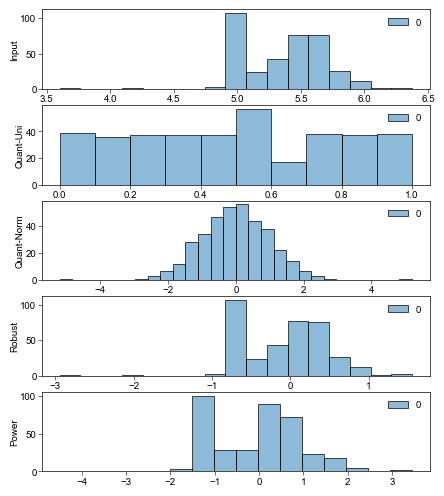

In [246]:
compare_transforms(input_df, 'maxN', log=True)

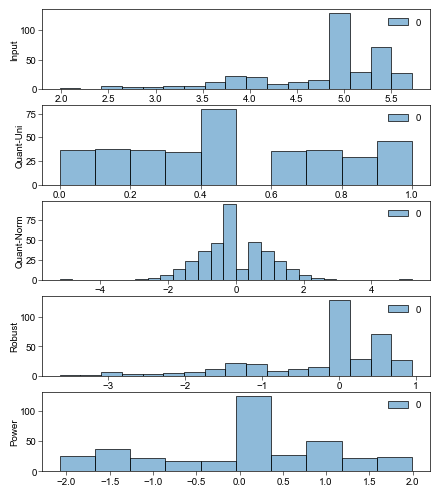

In [247]:
compare_transforms(input_df, 'minN', log=True)

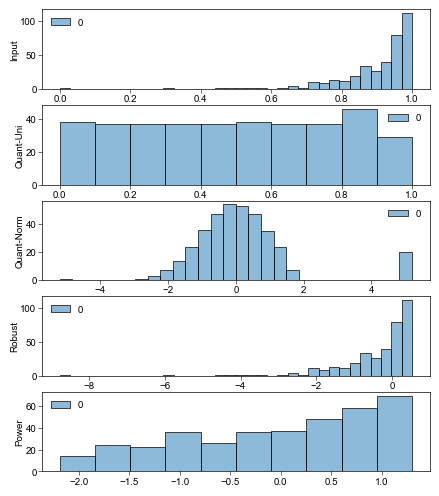

In [217]:
compare_transforms(input_df, 'meanCosine', log=False)

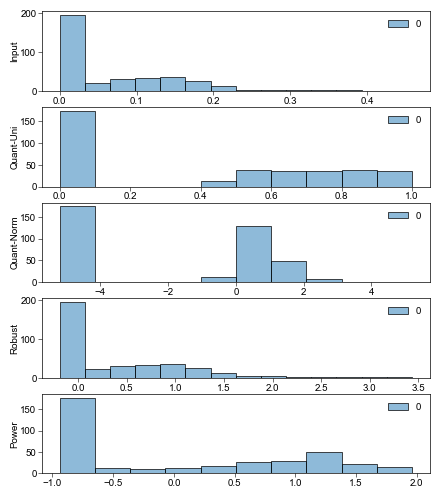

In [219]:
compare_transforms(input_df, 'jaccard', log=False)

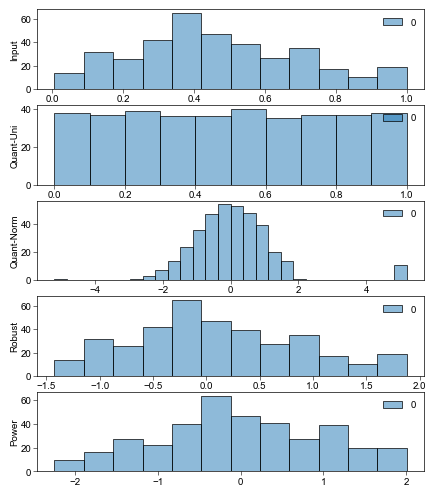

In [234]:
compare_transforms(input_df, 'Gene_ratio', log=False)

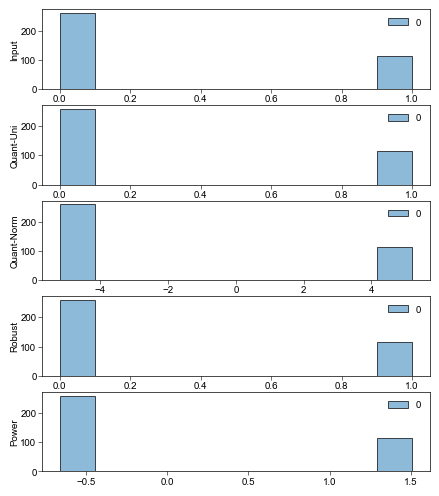

In [248]:
compare_transforms(input_df, 'binary', log=False)

## Fit models
### OLS Linear Regression

In [144]:
import statsmodels.api as sm
Xa = np.array(input_df[['maxN', 'minN', 'meanCosine', 'Gene_ratio', 'binary']])
Xb = np.array(input_df[['jaccard', 'jaccard_zero']])
transformer1 = prep.QuantileTransformer(n_quantiles=len(Xa)).fit(Xa)
transformer2 = prep.RobustScaler().fit(Xb)
Xa_scaled = transformer1.transform(Xa)
Xb_scaled = transformer2.transform(Xb)
X_scaled = np.concatenate([Xa_scaled, Xb_scaled], axis=1)
X2 = sm.add_constant(X_scaled)

In [145]:
y = input_df.log2SizeOE.values.reshape(-1,1)

In [146]:
model = sm.OLS(y, X2).fit()
pred  = model.predict(X2)

In [147]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     189.2
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          2.64e-117
Time:                        12:07:27   Log-Likelihood:                -206.46
No. Observations:                 373   AIC:                             428.9
Df Residuals:                     365   BIC:                             460.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5164      0.085     17.924      0.0

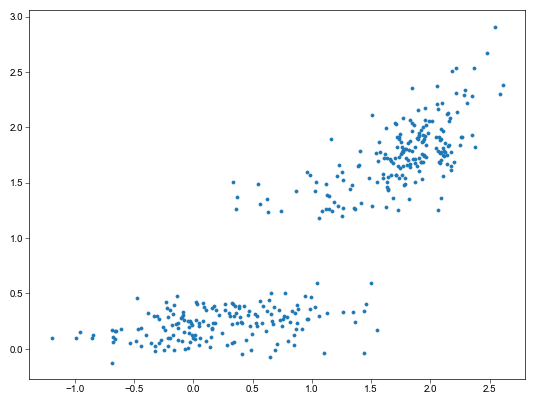

In [24]:
plt.scatter(x=y, y=pred, s=5)

### Ridge

[[ 0.         -0.28421145 -0.0264389   0.05827288 -0.19521659  0.23250801
   0.49838473 -1.05538424]]
0.7839693834793086
0.7839693834793086


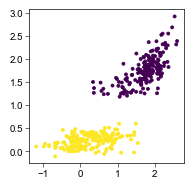

In [26]:
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score
reg = linear_model.Ridge(alpha=0.5, fit_intercept=True)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5, c=X2[:, -1])

### Lasso

[ 0.         -0.         -0.          0.         -0.          0.00871554
  0.44230194 -1.00020558]
0.7642337687053359
0.764233768705336


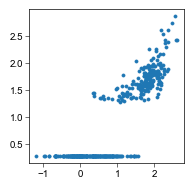

In [149]:
reg = linear_model.Lasso(alpha=0.02)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5)

### Elastic Net

[ 0.         -0.          0.          0.         -0.         -0.
  0.49153498 -0.68731805]
0.7299130327276523
0.7299130327276523


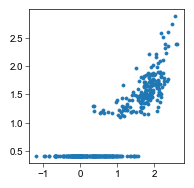

In [36]:
reg = linear_model.ElasticNet(alpha=0.1)
reg.fit(X2, y)
y_pred = reg.predict(X2)
print(reg.coef_)
print(r2_score(y, y_pred))
print(explained_variance_score(y, y_pred))
_ = plt.figure(figsize=(2,2))
plt.scatter(x=y, y=y_pred, s=5)

## Regress out Jaccard similarity

Regress out of the traits with shared genes only? Then Adjust to retain intercept?

In [95]:
input_df.head()

,log2SizeOE,logq,jaccard,maxN,minN,meanCosine,Gene_ratio,binary,jaccard_zero
EFO,,,,,,,,,
EFO_0004533,2.609069,250.0,0.333333,437896.0,256510.000000,0.910696,0.500000,0,0
EFO_0005091,2.584653,250.0,0.333333,443529.0,418415.969697,0.796182,0.750000,0,0
EFO_0006925,2.541330,250.0,0.458333,284044.0,146248.000000,0.901635,0.521739,0,0
EFO_0007805,2.474827,250.0,0.424242,400754.0,378175.226277,0.855174,0.880000,0,0
EFO_0004531,2.375897,250.0,0.176471,437354.0,182537.000000,0.846892,0.333333,0,0


In [182]:
Xb = np.array(input_df[['binary', 'jaccard','jaccard_zero']])
X2 = sm.add_constant(Xb)

In [183]:
y = input_df.log2SizeOE.values.reshape(-1,1)

In [184]:
model = sm.OLS(y, X2).fit()
pred  = model.predict(X2)

In [185]:
residuals = model.resid

In [186]:
y_adjusted = residuals + model.params[0]

In [187]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     417.0
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          3.93e-118
Time:                        12:12:45   Log-Likelihood:                -216.36
No. Observations:                 373   AIC:                             440.7
Df Residuals:                     369   BIC:                             456.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2542      0.060     21.055      0.0

(array([ 3.,  3.,  5.,  8.,  9., 14., 24., 34., 43., 55., 53., 50., 27.,
        18., 15.,  3.,  1.,  4.,  2.,  2.]),
 array([-0.06988439,  0.06726587,  0.20441613,  0.34156639,  0.47871665,
         0.61586691,  0.75301717,  0.89016743,  1.02731769,  1.16446795,
         1.30161821,  1.43876847,  1.57591873,  1.71306899,  1.85021925,
         1.98736952,  2.12451978,  2.26167004,  2.3988203 ,  2.53597056,
         2.67312082]),
 <BarContainer object of 20 artists>)

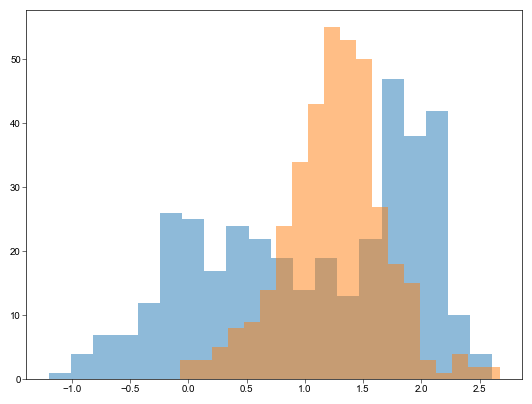

In [188]:
plt.hist(y, alpha=0.5, bins=20)
plt.hist(y_adjusted , alpha=0.5, bins=20)

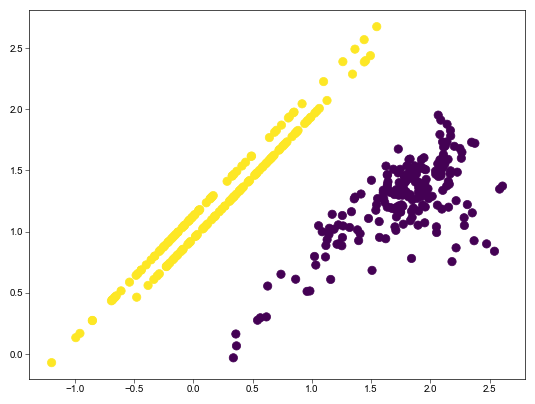

In [189]:
plt.scatter(y, y_adjusted, c=X2[:,-1])

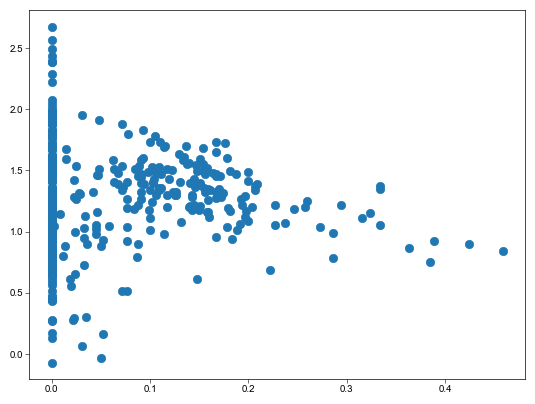

In [190]:
plt.scatter(input_df.jaccard, y_adjusted)

In [191]:
input_df['AdjustedColoc'] = y_adjusted

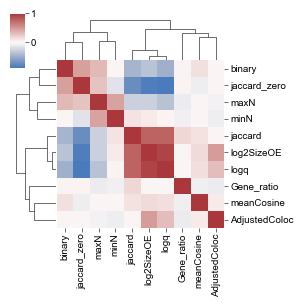

In [192]:
sns.clustermap(input_df.corr(), figsize=(3,3), cmap='vlag', center=0)

### Adjusted vs other input features

In [193]:
ya = input_df.AdjustedColoc.values.reshape(-1,1)

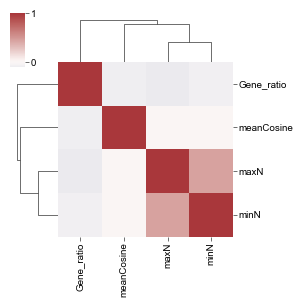

In [198]:
sns.clustermap(input_df[['maxN', 'minN', 'meanCosine', 'Gene_ratio']].corr(), figsize=(3,3), cmap='vlag', center=0)

In [203]:
Xa = np.array(input_df[['maxN','minN' ,'meanCosine', 'Gene_ratio']])
transformer1 = prep.QuantileTransformer(n_quantiles=len(Xa)).fit(Xa)
Xa_scaled = transformer1.transform(Xa)
X2 = sm.add_constant(Xa)

In [204]:
model2 = sm.OLS(ya, X2).fit()
pred  = model2.predict(X2)

In [205]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.723
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0293
Time:                        12:14:16   Log-Likelihood:                -210.92
No. Observations:                 373   AIC:                             431.8
Df Residuals:                     368   BIC:                             451.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1531      0.193      5.984      0.0

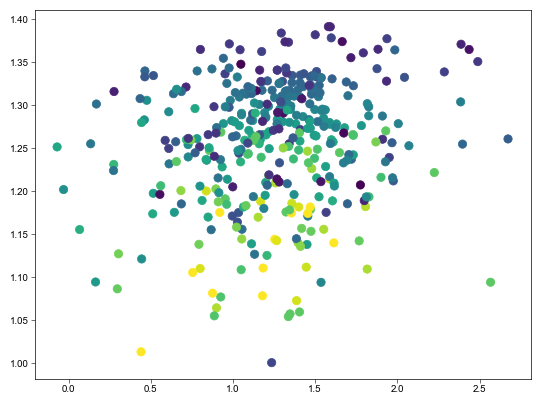

In [206]:
plt.scatter(ya, pred, c=X2[:, -1])

# Network features

In [263]:
input_df.head()

,log2SizeOE,logq,jaccard,maxN,minN,meanCosine,Gene_ratio,binary,jaccard_zero,AdjustedColoc
EFO,,,,,,,,,,
EFO_0004533,2.609069,250.0,0.333333,437896.0,256510.000000,0.910696,0.500000,0,0,1.371502
EFO_0005091,2.584653,250.0,0.333333,443529.0,418415.969697,0.796182,0.750000,0,0,1.347085
EFO_0006925,2.541330,250.0,0.458333,284044.0,146248.000000,0.901635,0.521739,0,0,0.839675
EFO_0007805,2.474827,250.0,0.424242,400754.0,378175.226277,0.855174,0.880000,0,0,0.899741
EFO_0004531,2.375897,250.0,0.176471,437354.0,182537.000000,0.846892,0.333333,0,0,1.720714


In [484]:
Xnet = net_df.merge(input_df.loc[:, ('AdjustedColoc')].reset_index(), on='EFO')

In [485]:
Xnet.head()

,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort,n_rare,n_common,n_overlap,trait_pair,EFO,Modularity,SubnetMod,AdjustedColoc
0,rare,0.250000,3,314.125000,1.750000,0.204771,0.291667,0.005247,1.821429,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000003,NaN,1.371502
1,common,0.116667,7,284.000000,1.750000,0.236188,0.200000,0.005575,2.050000,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000007,NaN,1.371502
2,overlap,0.266667,2,289.666667,1.333333,0.201191,0.000000,0.004378,1.866667,NaN,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000002,NaN,1.371502
3,rare_common,0.130719,8,295.500000,2.222222,0.235343,0.303704,0.006835,2.026144,0.007724,8,16,6,34375979_EFO_0004533_GCST90025947_EFO_0004533,EFO_0004533,0.000009,0.065,1.371502
4,rare,0.227273,2,400.916667,2.500000,0.228749,0.302778,0.005615,1.787879,NaN,12,16,7,34662886_EFO_0005091_GCST90025950_EFO_0005091,EFO_0005091,0.000007,NaN,1.347085


## Feature correlations + values

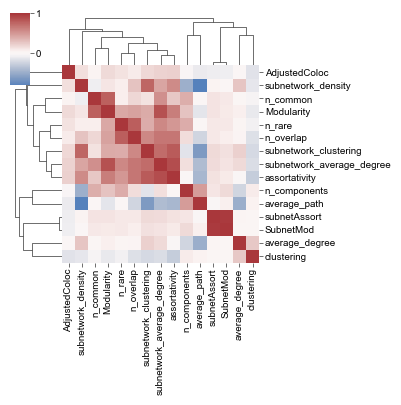

In [486]:
sns.clustermap(Xnet[Xnet.varset=='rare_common'].drop(columns=['varset', 'EFO', 'trait_pair']).corr(), figsize=(4,4), cmap='vlag', center=0)

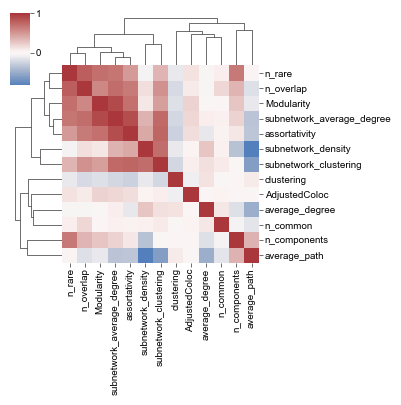

In [489]:
sns.clustermap(Xnet[Xnet.varset=='rare'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

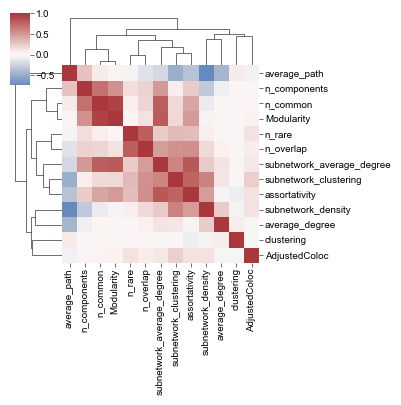

In [490]:
sns.clustermap(Xnet[Xnet.varset=='common'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

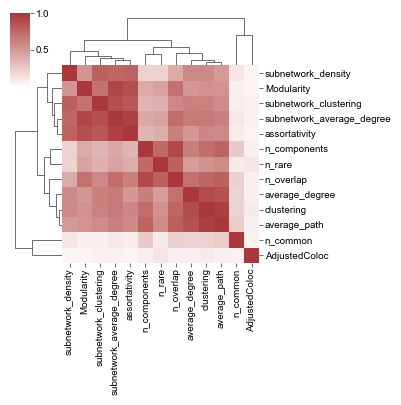

In [491]:
sns.clustermap(Xnet[Xnet.varset=='overlap'].drop(columns=['varset', 'EFO', 'trait_pair', 'subnetAssort', 'SubnetMod']).dropna().corr(), figsize=(4,4), cmap='vlag', center=0)

## Feature normalization

In [330]:
Xnet.columns

Index(['varset', 'subnetwork_density', 'n_components', 'average_degree',
       'subnetwork_average_degree', 'clustering', 'subnetwork_clustering',
       'assortativity', 'average_path', 'subnetAssort', 'n_rare', 'n_common',
       'n_overlap', 'trait_pair', 'EFO', 'AdjustedColoc'],
      dtype='object')

In [339]:
sep_net = Xnet.loc[Xnet.varset.isin(['rare', 'common']), ('EFO', 'average_degree', 'clustering')]


In [340]:
sep_net = sep_net.groupby('EFO').agg(
    deg_min=pd.NamedAgg(column="average_degree", aggfunc="min"),
    deg_max=pd.NamedAgg(column="average_degree", aggfunc="max"),
    deg_mean=pd.NamedAgg(column="average_degree", aggfunc="mean"),
    c_min=pd.NamedAgg(column="clustering", aggfunc="min"),
    c_max=pd.NamedAgg(column="clustering", aggfunc="max"),
    c_mean=pd.NamedAgg(column="clustering", aggfunc="mean")
).reset_index()

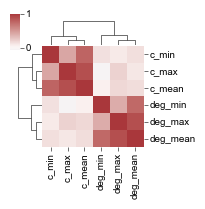

In [341]:
sns.clustermap(sep_net.corr(numeric_only=True, method='spearman'), figsize=(2,2), cmap='vlag', center=0)

In [342]:
both_net = Xnet.loc[Xnet.varset.isin(['rare_common']), ('EFO', 'subnetAssort', 'subnetwork_clustering','clustering', 'average_degree')]


In [343]:
all_x = sep_net.merge(both_net, on='EFO').merge(input_df.reset_index().loc[:, ('EFO', 'AdjustedColoc', 'log2SizeOE', 'jaccard')])

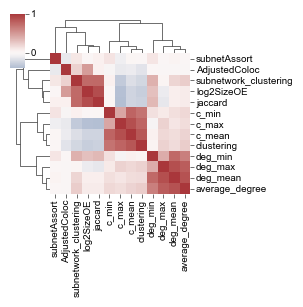

In [344]:
sns.clustermap(all_x.corr(numeric_only=True, method='spearman'), figsize=(3,3), cmap='vlag', center=0)

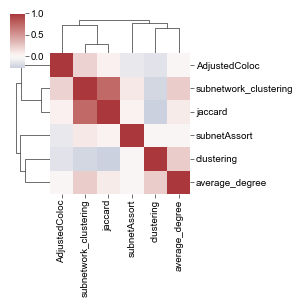

In [348]:
sns.clustermap(all_x.loc[:, ('subnetAssort', 'subnetwork_clustering', 'clustering', 'average_degree', 'AdjustedColoc', 'jaccard')].corr(numeric_only=True, method='spearman'), figsize=(3,3), cmap='vlag', center=0)

In [364]:
X_net2 = all_x.loc[:, ('subnetAssort', 'subnetwork_clustering', 'clustering', 'average_degree', 'AdjustedColoc', 'jaccard')]

In [365]:
X_net2.describe()

,subnetAssort,subnetwork_clustering,clustering,average_degree,AdjustedColoc,jaccard
count,332.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,-0.054839,0.216871,0.274273,425.991004,1.254218,0.069432
std,0.228442,0.175120,0.030132,112.359697,0.432772,0.088884
min,-1.000000,0.000000,0.187181,77.333333,-0.069884,0.000000
25%,-0.116046,0.000000,0.255479,364.285714,0.998819,0.000000
50%,-0.037155,0.230769,0.270136,418.705263,1.281609,0.023810
75%,0.018871,0.360920,0.289703,468.428571,1.505130,0.126582
max,1.000000,0.742857,0.370070,969.538462,2.673121,0.458333


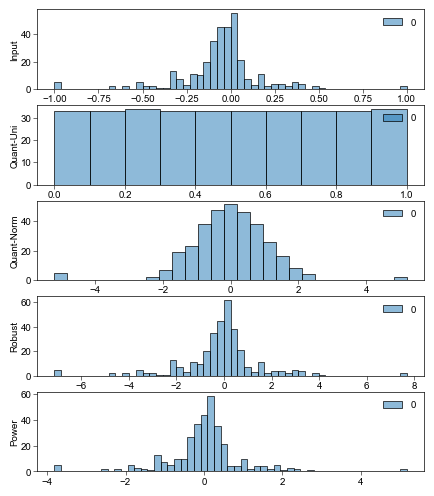

In [366]:
compare_transforms(X_net2, 'subnetAssort', log=False)

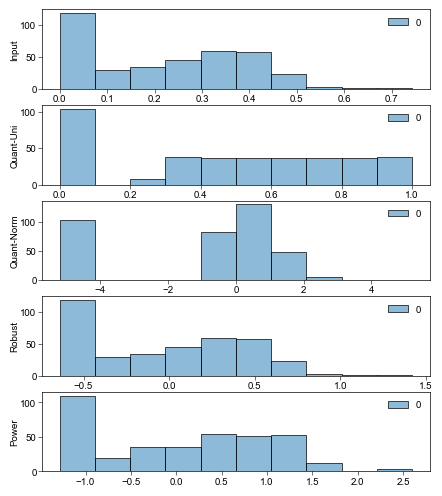

In [354]:
compare_transforms(X_net2, 'subnetwork_clustering', log=False)

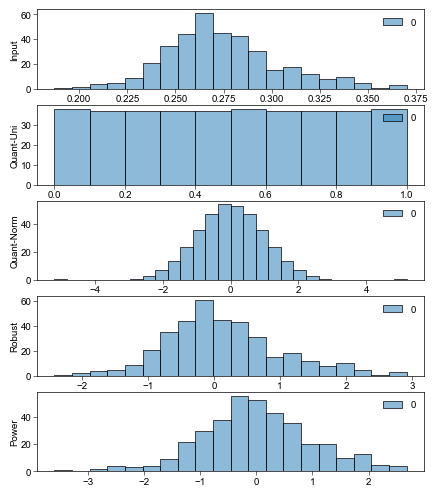

In [355]:
compare_transforms(X_net2, 'clustering', log=False)

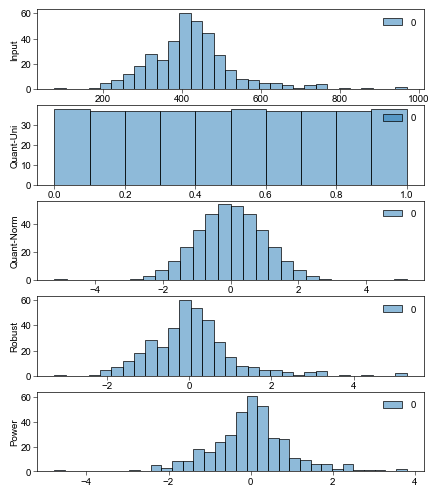

In [356]:
compare_transforms(X_net2, 'average_degree', log=False)

In [ ]:
# clustering=0 means there are no triangles in the data.

# Power transform for: subnetAssort, clustering, average degree, 
# subnetwork_clustering is a little bit suss, but there are a lot of zeros so...

## Regression Analysis

In [402]:
import statsmodels.api as sm
Xa = np.array(X_net2[['subnetAssort', 'clustering', 'average_degree', 'subnetwork_clustering']].fillna(0))
#Xb = np.array(input_df[['subnetwork_clustering']])
transformer1 = prep.PowerTransformer().fit(Xa)
#transformer2 = prep.RobustScaler().fit(Xb)
Xa_scaled = transformer1.transform(Xa)
#Xb_scaled = transformer2.transform(Xb)
#X_scaled = np.concatenate([Xa_scaled, Xb_scaled], axis=1)
X_net3 = sm.add_constant(Xa_scaled)

In [403]:
y = X_net2.AdjustedColoc.values.reshape(-1,1)
y2 = X_net2.jaccard.values.reshape(-1,1)

In [407]:
model = sm.OLS(y, X_net3).fit()
model2 = sm.OLS(y2, X_net3).fit()
pred  = model.predict(X_net3)
pred2 = model2.predict(X_net3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     6.551
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           4.22e-05
Time:                        15:37:50   Log-Likelihood:                -203.53
No. Observations:                 373   AIC:                             417.1
Df Residuals:                     368   BIC:                             436.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2542      0.022     57.618      0.0

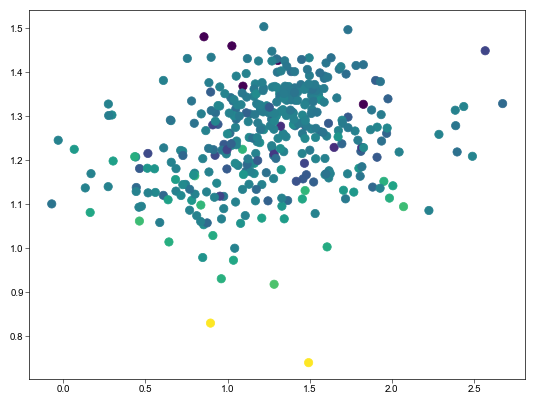

In [414]:
print(model.summary())
plt.scatter(y, pred, c=X_net3[:, -4])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     67.43
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           9.13e-43
Time:                        15:36:53   Log-Likelihood:                 476.60
No. Observations:                 373   AIC:                            -943.2
Df Residuals:                     368   BIC:                            -923.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0694      0.004     19.753      0.0

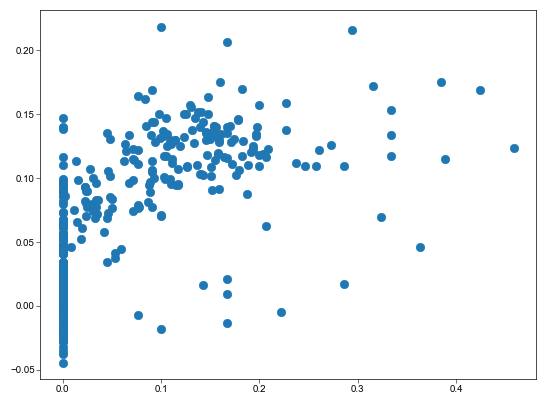

In [412]:
print(model2.summary())
plt.scatter(y2, pred2)

In [419]:
all_x.

(332, 14)

<Axes: xlabel='subnetAssort', ylabel='AdjustedColoc'>

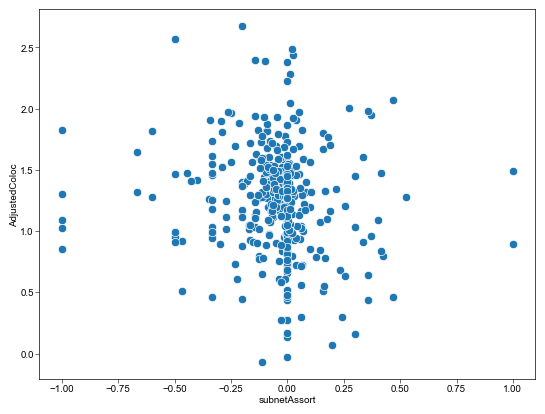

In [424]:
sns.scatterplot(all_x.fillna(0), x='subnetAssort', y='AdjustedColoc')

<Axes: xlabel='subnetwork_clustering', ylabel='AdjustedColoc'>

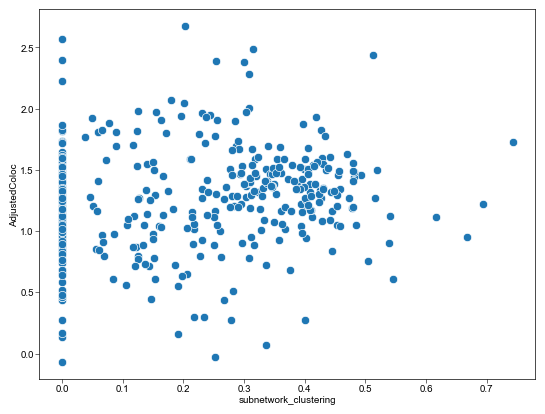

In [425]:
sns.scatterplot(all_x.fillna(0), x='subnetwork_clustering', y='AdjustedColoc')

<Axes: xlabel='subnetwork_clustering', ylabel='jaccard'>

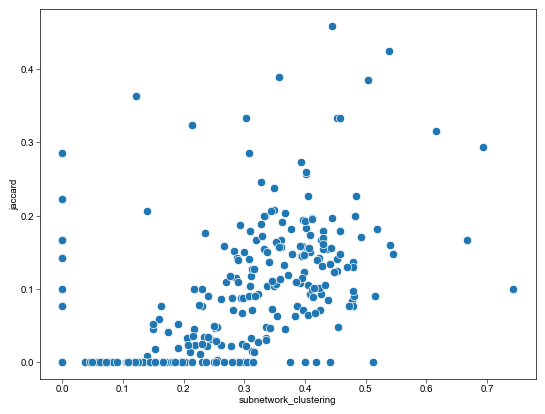

In [428]:
sns.scatterplot(all_x.fillna(0), x='subnetwork_clustering', y='jaccard')

## Feature normalization

# Bio features